## Finetuning UNet semantic segmentation model on the Stanford Backgrounds dataset
Code here is adapted from the work of Balraj Ashwath: https://github.com/BalrajAshwath/Semantic-Segmentation-Suite

We train the decoder, and use a frozen encoder. 

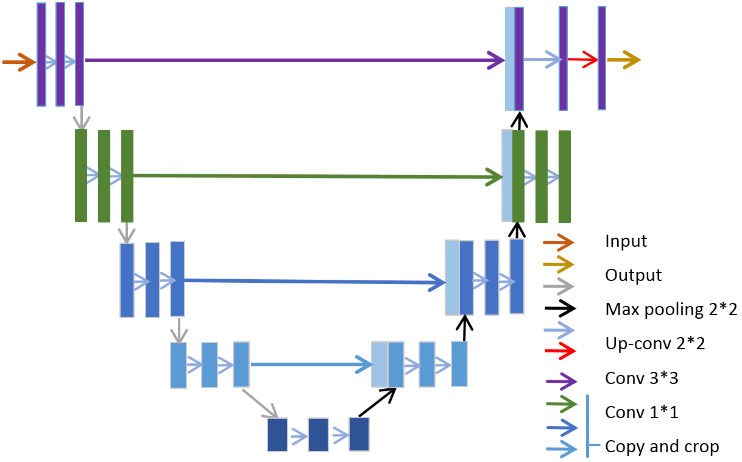

### Import relevant libraries

In [1]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

#### UNet comes pretrained from **segmentation_models_pytorch**

In [2]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

#### Get metadata to read files from dataset

In [3]:
DATA_DIR = '/content/drive/Shareddrives/VIP Project/stanford-backgrounds'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[['image_id', 'image_path', 'label_colored_path']]
metadata_df['image_path'] = metadata_df['image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['label_colored_path'] = metadata_df['label_colored_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)


(643, 72)

In [4]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'labels_class_dict.csv'))
class_names = class_dict['class_names'].tolist()
class_rgb_values = class_dict[['r','g','b']].values.tolist()
select_classes = ['sky', 'tree', 'road', 'grass', 'water', 'building', 'mountain', 'foreground', 'unknown']

select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['sky', 'tree', 'road', 'grass', 'water', 'building', 'mountain', 'foreground', 'unknown']
Class RGB values:  [[68, 1, 84], [72, 40, 140], [62, 74, 137], [38, 130, 142], [31, 158, 137], [53, 183, 121], [109, 205, 89], [180, 222, 44], [49, 104, 142]]


### Helper functions to:
1. Visualise a set of images
2. One Hot Encode each pixel, so the depth of each pixel is the number of possible output classes
3. Reverse One Hot Encoding- Convert one hot labels to single class labels for each pixel
4. Colour Code Segmentation- Assign a colour to each pixel for visualisation

In [5]:
# helper function for data visualization
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

### Convert dataset into a class object consumable by model
Code from Ashwath

In [6]:
# extend pytorch dataset
# based on work of Balraj Ashwatch Scene Parsing notebook
class BackgroundDataset(torch.utils.data.Dataset):
    """Stanford Background Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['image_path'].tolist()
        self.mask_paths = df['label_colored_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

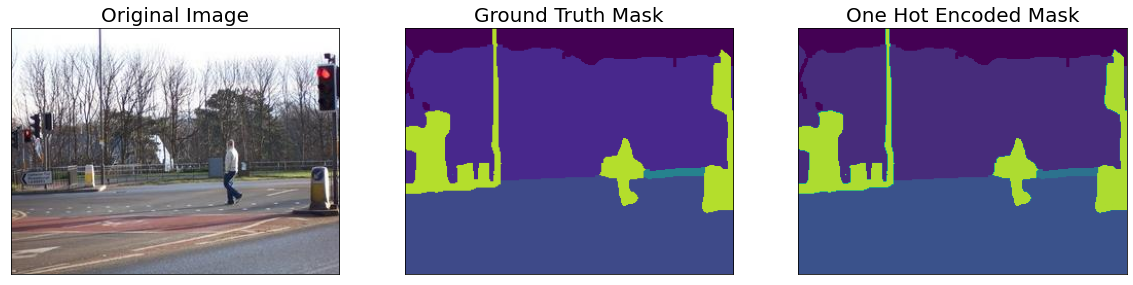

In [7]:
dataset = BackgroundDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(original_image = image, ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values), one_hot_encoded_mask = reverse_one_hot(mask))

In [8]:
# Pad images to 320x320 and randomly flip and rotate images to grow dataset
def get_training_augmentation():
    train_transform = [album.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0), album.OneOf( [ album.VerticalFlip(p=1), album.RandomRotate90(p=1), album.HorizontalFlip(p=1) ], p=0.5, )]
    return album.Compose(train_transform)


# Do the same for validation dataset
def get_validation_augmentation():
  test_transform = [ album.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0), ]
  return album.Compose(test_transform)

# Pytorch does not use the same formatting as tensorflow
# images are now (channels, height, width)
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


# pass in preprocessng function from UNet using albumentation
# basically a black box, don't know how UNet is preprocessing data
def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

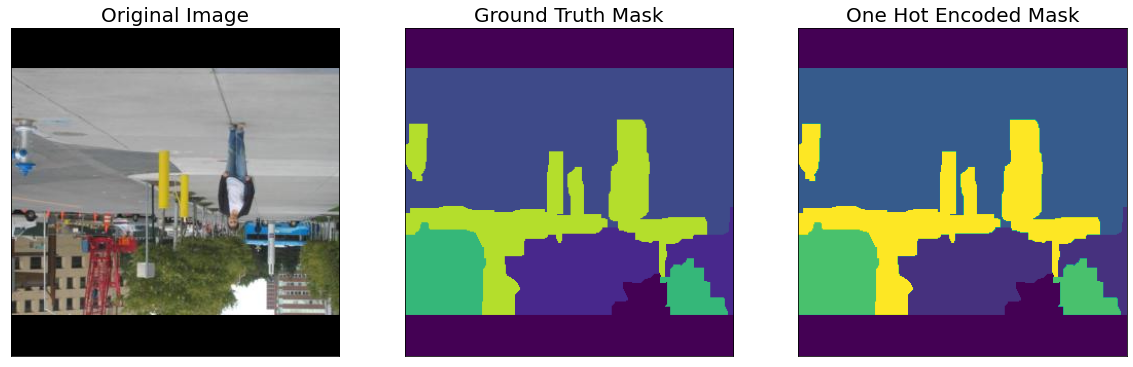

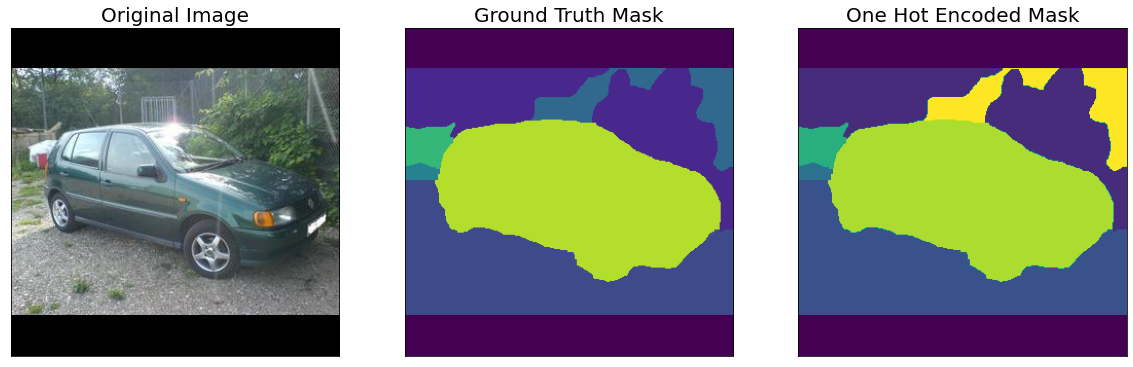

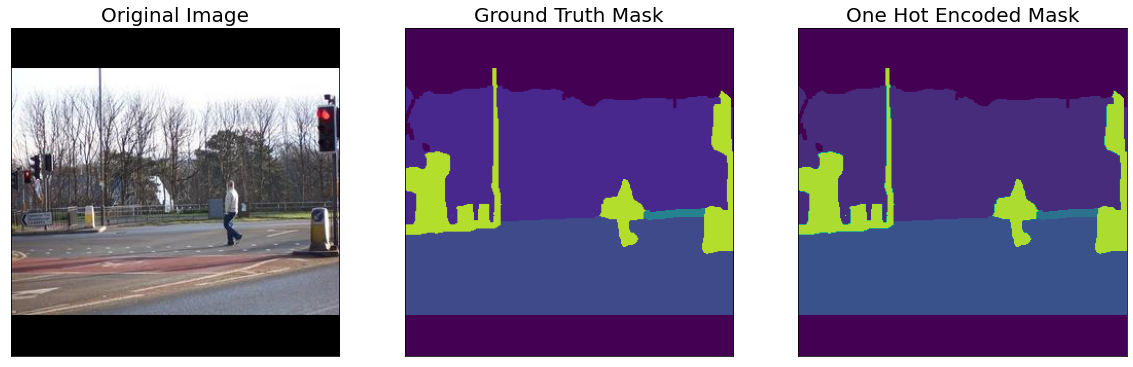

In [9]:
augmented_dataset = BackgroundDataset(train_df, augmentation=get_training_augmentation(), class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on image/mask pairs
for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize( original_image = image, ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values), one_hot_encoded_mask = reverse_one_hot(mask))

#### UNet model with 8 possible output classes
Uses ResNet50 skeleton and imagenet weights, sigmoid activation

In [10]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid'

# create segmentation model with pretrained encoder
model = smp.Unet(encoder_name='resnet50', encoder_weights='imagenet', classes=len(CLASSES), activation='sigmoid')
# unet makes it's own preprocessing function so just use that lah
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [11]:
!pip install --upgrade albumentations

In [12]:
import albumentations as album

train_dataset = BackgroundDataset( train_df, augmentation=get_training_augmentation(), preprocessing=get_preprocessing(preprocessing_fn), class_rgb_values=select_class_rgb_values )
valid_dataset = BackgroundDataset( valid_df, augmentation=get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn), class_rgb_values=select_class_rgb_values )

# use batch size of 16 and create torch data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=4)

In [13]:
TRAINING = True
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# don't know why using this loss, but recommended for UNet
loss = smp.utils.losses.DiceLoss()
# Intersection Over Union to judge performance of segmentation with threshold of 0.5
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
# Adam optimizer
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001)])
model = torch.load(DATA_DIR + '/trained-model', map_location=DEVICE)

In [14]:
train_epoch = smp.utils.train.TrainEpoch(model, loss=loss, metrics=metrics, optimizer=optimizer, device=DEVICE, verbose=True)
valid_epoch = smp.utils.train.ValidEpoch(model, loss=loss, metrics=metrics, device=DEVICE, verbose=True)

In [15]:
model_path = DATA_DIR + '/trained-model'

Because of Colab compute limits, we train 2 rounds of 30 epochs each. Models are saved at the best IOU score.

In [ ]:
# Train and save best model
best_iou_score = 0
train_logs_list, valid_logs_list = [], []
for i in range(0, EPOCHS):
  # Perform training & validation
  print('\nEpoch: {}'.format(i))
  train_logs = train_epoch.run(train_loader)
  valid_logs = valid_epoch.run(valid_loader)
  train_logs_list.append(train_logs)
  valid_logs_list.append(valid_logs)
  # Save model if a better val IoU score is obtained
  if best_iou_score < valid_logs['iou_score']:
      best_iou_score = valid_logs['iou_score']
      torch.save(model, model_path)
      print('Model saved!')


Epoch: 0
valid: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it, dice_loss - 0.1017, iou_score - 0.8549]
Model saved!

Epoch: 1
valid: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s, dice_loss - 0.1019, iou_score - 0.8551]
Model saved!

Epoch: 2
valid: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s, dice_loss - 0.1012, iou_score - 0.8558]
Model saved!

Epoch: 3
valid: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s, dice_loss - 0.1013, iou_score - 0.8558]
Model saved!

Epoch: 4
valid: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s, dice_loss - 0.1011, iou_score - 0.8556]

Epoch: 5
valid: 100%|██████████| 5/5 [00:04<00:00,  1.20it/s, dice_loss - 0.1003, iou_score - 0.8576]
Model saved!

Epoch: 6
valid: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s, dice_loss - 0.09992, iou_score - 0.8584]
Model saved!

Epoch: 7
valid: 100%|██████████| 5/5 [00:04<00:00,  1.24it/s, dice_loss - 0.1008, iou_score - 0.8572]

Epoch: 8
valid: 100%|██████████| 5/5 [00:04<00:00,  1.18it/s, dice_loss - 0.101, iou_score - 0.8

## Evaluation of results

In [18]:
test_dataset = BackgroundDataset( valid_df, augmentation=get_validation_augmentation(), preprocessing=get_preprocessing(preprocessing_fn), class_rgb_values=select_class_rgb_values)
test_dataloader = DataLoader(test_dataset)

In [20]:
test_epoch = smp.utils.train.ValidEpoch(model, loss=loss, metrics=metrics, device=DEVICE, verbose=True)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Average IoU Score: {valid_logs['iou_score']}")
print(f"Average Dice Loss: {valid_logs['dice_loss']}")

valid: 100%|██████████| 72/72 [00:07<00:00,  9.84it/s, dice_loss - 0.08801, iou_score - 0.8819]
Evaluation on Test Data: 
Average IoU Score: 0.8818828446997538
Average Dice Loss: 0.0880057397815916


Best IOU score: 0.8584
Best Dice Loss: 0.09992

The training results above are produced during the second run of 30 epochs, not the first. After each round, the model was saved in Google Colab and reloaded to thwart compute limitations.

### Pipeline moved to app script and trained model loaded within the app

## Unsuccessful attempts to finetune DeepLab
Because this failed, we use UNet instead.

In [ ]:
import tensorflow as tf
import os
import cv2

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255
  input_mask -= 1
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask  

In [ ]:
dataPath = '/content/drive/Shareddrives/VIP Project/stanford-backgrounds'
images = []
for img in sorted(os.listdir(dataPath + '/images')):
  images.append(cv2.imread(dataPath + '/images/' + img))  
masks = []
for img in sorted(os.listdir(dataPath + '/labels_colored')):
  masks.append(cv2.imread(dataPath + '/labels_colored/' + img))

In [ ]:
import pickle

with open(dataPath + '/images.pkl', 'wb') as f:
  pickle.dump(images, f)

with open(dataPath + '/masks.pkl', 'wb') as f:
  pickle.dump(masks, f)

In [ ]:
image_masks = []
for i in range(len(images)):
  image_masks.append({'image': images[i], 'segmentation_mask': masks[i]})

TRAIN_LENGTH = 570
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train = image_masks[:TRAIN_LENGTH]
test = image_masks[TRAIN_LENGTH:]
train_images = [load_image(i) for i in train]
test_images = [load_image(i) for i in test]

In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

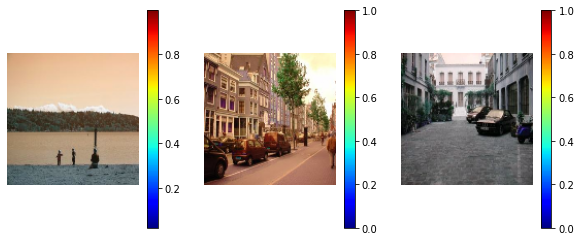

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
for i in range(1,4):
     plt.subplot(1,3,i)
     img = train_images[i][0]
     plt.imshow(img, cmap='jet')
     plt.colorbar()
     plt.axis('off')
plt.show() 

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-lmgjbqjp
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-lmgjbqjp


In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
class_names = ['sky', 'tree', 'road', 'grass', 'water', 'building', 'mountain', 'foreground', 'unknown']

model = unet_model(output_channels=len(class_names))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
train_x = [x[0] for x in train_images]
train_y = [y[1] for y in train_images]

test_x = [x[0] for x in test_images]
test_y = [y[1] for y in test_images]

train_x = tf.data.Dataset.from_tensor_slices(train_x)
train_y = tf.data.Dataset.from_tensor_slices(train_y)

test_x = tf.data.Dataset.from_tensor_slices(test_x)
test_y = tf.data.Dataset.from_tensor_slices(test_y)

train = tf.data.Dataset.zip((train_x, train_y))
test = tf.data.Dataset.zip((test_x, test_y))

In [ ]:
 def brightness(img, mask):
     img = tf.image.adjust_brightness(img, 0.1)
     return img, mask
 
 def gamma(img, mask):
     img = tf.image.adjust_gamma(img, 0.1)
     return img, mask

 def hue(img, mask):
     img = tf.image.adjust_hue(img, -0.1)
     return img, mask

 def crop(img, mask):
     img = tf.image.central_crop(img, 0.7)
     img = tf.image.resize(img, (128,128))
     mask = tf.image.central_crop(mask, 0.7)
     mask = tf.image.resize(mask, (128,128))
     mask = tf.cast(mask, tf.float32)
     return img, mask

 def flip_hori(img, mask):
     img = tf.image.flip_left_right(img)
     mask = tf.image.flip_left_right(mask)
     return img, mask

 def flip_vert(img, mask):
     img = tf.image.flip_up_down(img)
     mask = tf.image.flip_up_down(mask)
     return img, mask

 def rotate(img, mask):
     img = tf.image.rot90(img)
     mask = tf.image.rot90(mask)
     return img, mask 

In [ ]:
 # perform augmentation on train data only
 a = train.map(brightness)
 b = train.map(gamma)
 c = train.map(hue)
 d = train.map(crop)
 e = train.map(flip_hori)
 f = train.map(flip_vert)
 g = train.map(rotate)

 train = train.concatenate(a)
 train = train.concatenate(b)
 train = train.concatenate(c)
 train = train.concatenate(d)
 train = train.concatenate(e)
 train = train.concatenate(f)
 train = train.concatenate(g)

In [ ]:
train

<ConcatenateDataset shapes: ((128, 128, 3), (128, 128, 3)), types: (tf.float32, tf.float32)>

In [ ]:
 BATCH = 64
 AT = tf.data.AUTOTUNE
 BUFFER = 500
 STEPS_PER_EPOCH = 800//BATCH
 VALIDATION_STEPS = 200//BATCH
 train = train.cache().shuffle(BUFFER).batch(BATCH).repeat()
 train = train.prefetch(buffer_size=AT)
 test = test.batch(BATCH) 

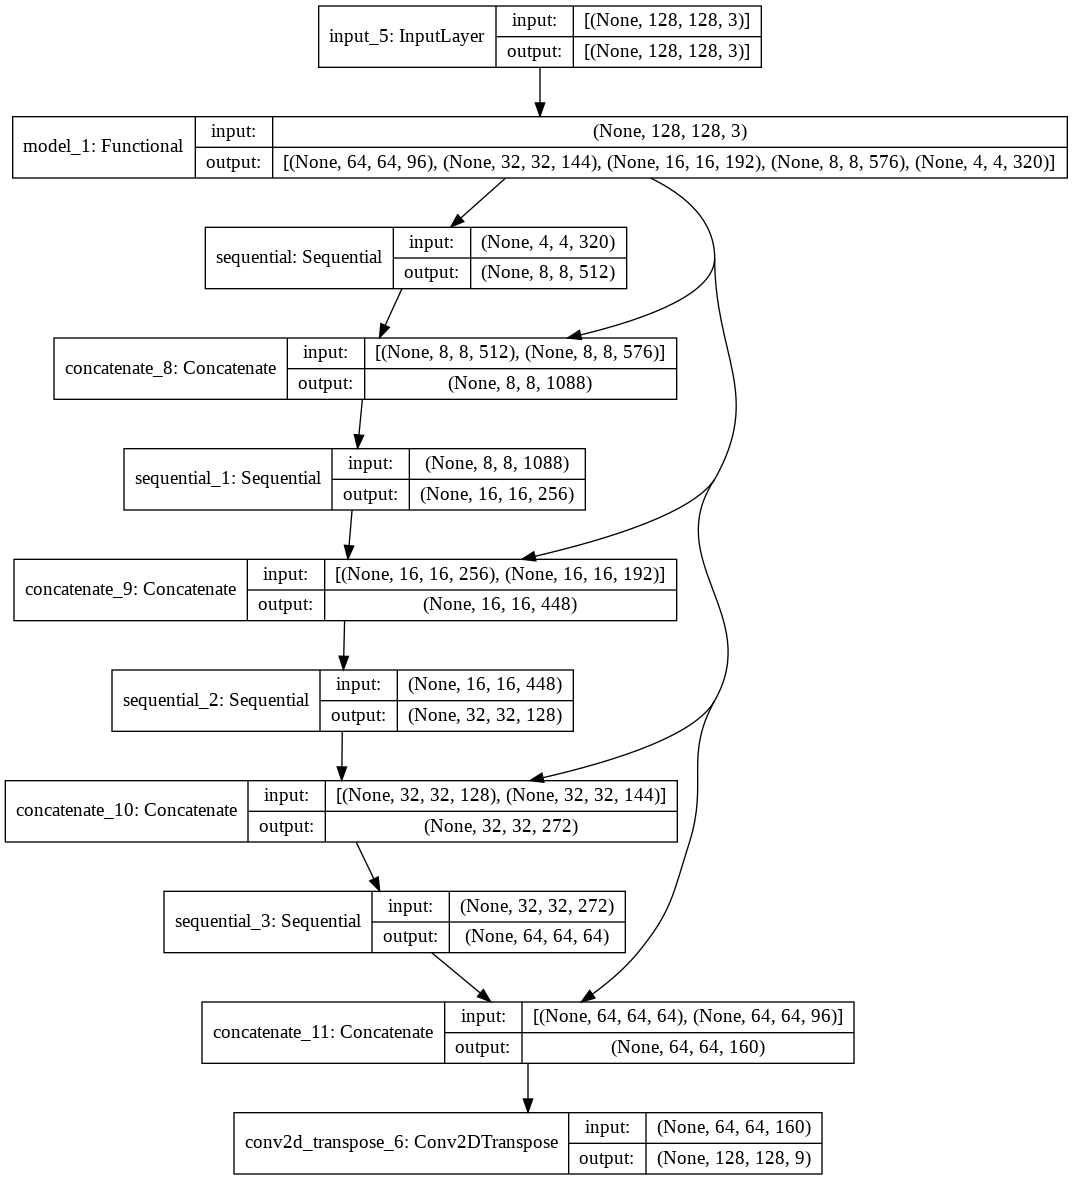

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
import pandas as pd
pd.Series(masks[0].ravel()).value_counts()

74     31041
62     31041
137    31041
121    26371
183    26371
53     26371
84     10089
68     10089
1      10089
222     8724
180     8724
44      8724
72       575
40       575
140      575
dtype: int64

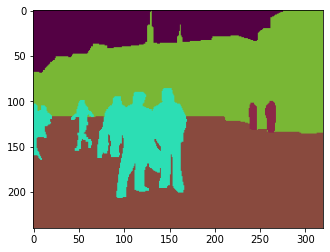

In [ ]:
plt.imshow(masks[0])

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            [(None, 64, 64, 96), 1841984     input_5[0][0]                    
__________________________________________________________________________________________________
sequential (Sequential)         (None, 8, 8, 512)    1476608     model_1[2][4]                    
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 8, 8, 1088)   0           sequential[2][0]                 
                                                                 model_1[2][3]              

In [ ]:
history = model.fit(train, steps_per_epoch=STEPS_PER_EPOCH, epochs=50)

Epoch 1/50


InvalidArgumentError: ignored